## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [15]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [16]:
data_dir = f"/home/nikhil/projects/NIMHANS/data/PD_SERB/"
session = "ses-01"
tabular_dir = f"{data_dir}/tabular/"

# mr_proc manifest
mr_proc_manifest_csv = f"{tabular_dir}/mr_proc_manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# imaging derivatives
FS_dir = f"{data_dir}/derivatives/freesurfer/v6.0.1/"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"
FS_DKT_dir = f"{FS_dir}/freesurfer-agg/{session}/"

DKT_csv = f"{FS_DKT_dir}/DKTatlas_average_thickness.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg_subcortical_volumes.csv"

# UKB encoding of FS fields (DKT + asg)
region_field_dir = "/home/nikhil/projects/Parkinsons/region_field_ids/"
ukbb_dkt_ct_fields = f"{region_field_dir}/UKBB_DKT_CT_Fields.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/UKBB_ASEG_vol_Fields.csv"

# save dirs
results_dir = "../agg_dfs/"
figs_dir = "../figs/"

### Colormaps

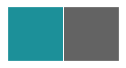

In [17]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### mr_proc manifest

In [18]:
manifest_cols = ["participant_id", "visit", "session", "bids_id"]

mr_proc_df = pd.read_csv(mr_proc_manifest_csv)
mr_proc_df = mr_proc_df[manifest_cols]

mr_proc_participants = mr_proc_df["participant_id"].unique()
n_mr_proc_participants = len(mr_proc_participants)
print(f"mr_proc participants: {n_mr_proc_participants}")
mr_proc_df.head()

mr_proc participants: 91


,participant_id,visit,session,bids_id
0,SERB001,V01,ses-01,sub-SERB001
1,SERB002,V01,ses-01,sub-SERB002
2,SERB003,V01,ses-01,sub-SERB003
3,SERB004,V01,ses-01,sub-SERB004
4,SERB005,V01,ses-01,sub-SERB005


### Demographic data

In [19]:
demographics_df = pd.read_csv(demographics_csv)
participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")
group_counts = demographics_df.groupby(["group"]).count()
print(f"group counts: {group_counts}")
demographics_df.head()

n_participants: 91
group counts:          participant_id  age  sex  visit
group                                   
PD                   69   56   58     69
control              22   15   15     22


,participant_id,age,sex,group,visit
0,SERB001,56.0,M,control,V01
1,SERB002,NaN,NaN,control,V01
2,SERB003,47.0,M,control,V01
3,SERB004,60.0,M,control,V01
4,SERB005,NaN,NaN,control,V01


### Merge demographics and mr_proc manifest

In [20]:
demographics_df = pd.merge(demographics_df, mr_proc_df, on=["participant_id", "visit"])
demographics_df.head()

,participant_id,age,sex,group,visit,session,bids_id
0,SERB001,56.0,M,control,V01,ses-01,sub-SERB001
1,SERB002,NaN,NaN,control,V01,ses-01,sub-SERB002
2,SERB003,47.0,M,control,V01,ses-01,sub-SERB003
3,SERB004,60.0,M,control,V01,ses-01,sub-SERB004
4,SERB005,NaN,NaN,control,V01,ses-01,sub-SERB005


### UKB - DKT - ASEG fields and names

In [21]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]

DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

lh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["Field ID"].values.astype("str"))
rh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["Field ID"].values.astype("str"))
rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])

# hemi specific dict
lh_DKT_field_roi_dict = dict(zip(lh_DKT_fields,rois))
rh_DKT_field_roi_dict = dict(zip(rh_DKT_fields,rois))


### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

ASEG_fields_sorted = list(ASEG_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

lh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["Field ID"].values.astype("str"))
rh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Right-"]["Field ID"].values.astype("str"))
global_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["Field ID"].values.astype("str"))
hemi_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["roi"])
global_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["roi"])

# hemi specific dict
lh_ASEG_field_roi_dict = dict(zip(lh_ASEG_fields,hemi_rois))
rh_ASEG_field_roi_dict = dict(zip(rh_ASEG_fields,hemi_rois))
global_ASEG_field_roi_dict = dict(zip(global_ASEG_fields,global_rois))
ASEG_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_ROI
0,43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle
1,44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle
2,45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle
3,46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area
4,47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area


### Read DKT data

In [22]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df = CT_DKT_df.drop(columns=["Unnamed: 0"])
CT_DKT_df = CT_DKT_df.rename(columns={"subject_id":"bids_id"})

bids_ids = CT_DKT_df["bids_id"].unique()
print(f"n_bids: {len(bids_ids)}")

CT_DKT_df = pd.merge(CT_DKT_df,demographics_df,on="bids_id",how="left")
CT_DKT_df.head()

CT_DKT_df.head()

n_bids: 86


,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27294,27295,27296,27297,participant_id,age,sex,group,visit,session
0,sub-SERB088,2.643,2.648,1.866,3.932,3.098,2.638,2.969,2.312,2.189,...,3.041,2.707,2.033,3.435,SERB088,54.0,M,PD,V01,ses-01
1,sub-SERB058,3.230,2.844,1.941,3.825,2.900,2.479,3.003,2.308,2.365,...,3.012,2.531,2.390,3.294,SERB058,64.0,M,PD,V01,ses-01
2,sub-SERB049,2.756,2.717,1.997,3.036,2.709,2.457,2.875,2.388,2.123,...,3.142,2.630,2.333,3.207,SERB049,62.0,M,PD,V01,ses-01
3,sub-SERB084,2.974,2.603,1.819,3.802,2.701,2.399,2.947,2.468,2.364,...,2.754,2.526,1.827,2.869,SERB084,NaN,NaN,PD,V01,ses-01
4,sub-SERB063,3.015,2.939,1.998,4.177,3.054,2.831,3.403,2.462,2.382,...,3.055,2.831,2.514,3.513,SERB063,56.0,M,PD,V01,ses-01


### Filter demographics based on available BIDS data

In [23]:
demographics_df = demographics_df[demographics_df["bids_id"].isin(bids_ids)]
demographics_df.head()

,participant_id,age,sex,group,visit,session,bids_id
0,SERB001,56.0,M,control,V01,ses-01,sub-SERB001
1,SERB002,NaN,NaN,control,V01,ses-01,sub-SERB002
2,SERB003,47.0,M,control,V01,ses-01,sub-SERB003
3,SERB004,60.0,M,control,V01,ses-01,sub-SERB004
4,SERB005,NaN,NaN,control,V01,ses-01,sub-SERB005


### Split DKT data into left and right hemisphere

In [24]:
save_results = False
demo_cols = ["participant_id","age","sex","group"]
lh_CT_DKT_df = CT_DKT_df[lh_DKT_fields + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[rh_DKT_fields + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_field_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_field_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{results_dir}/CT_DKT_df.csv")

CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,age,sex,group,hemi
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,2.916,2.200,3.044,2.717,2.386,SERB088,54.0,M,PD,lh
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,3.022,2.113,2.998,2.589,1.971,SERB058,64.0,M,PD,lh
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,2.605,2.224,2.912,2.526,1.875,SERB049,62.0,M,PD,lh
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,2.730,2.051,2.928,2.532,2.250,SERB084,NaN,NaN,PD,lh
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,3.160,2.434,3.118,2.933,2.776,SERB063,56.0,M,PD,lh


### Plot DKT

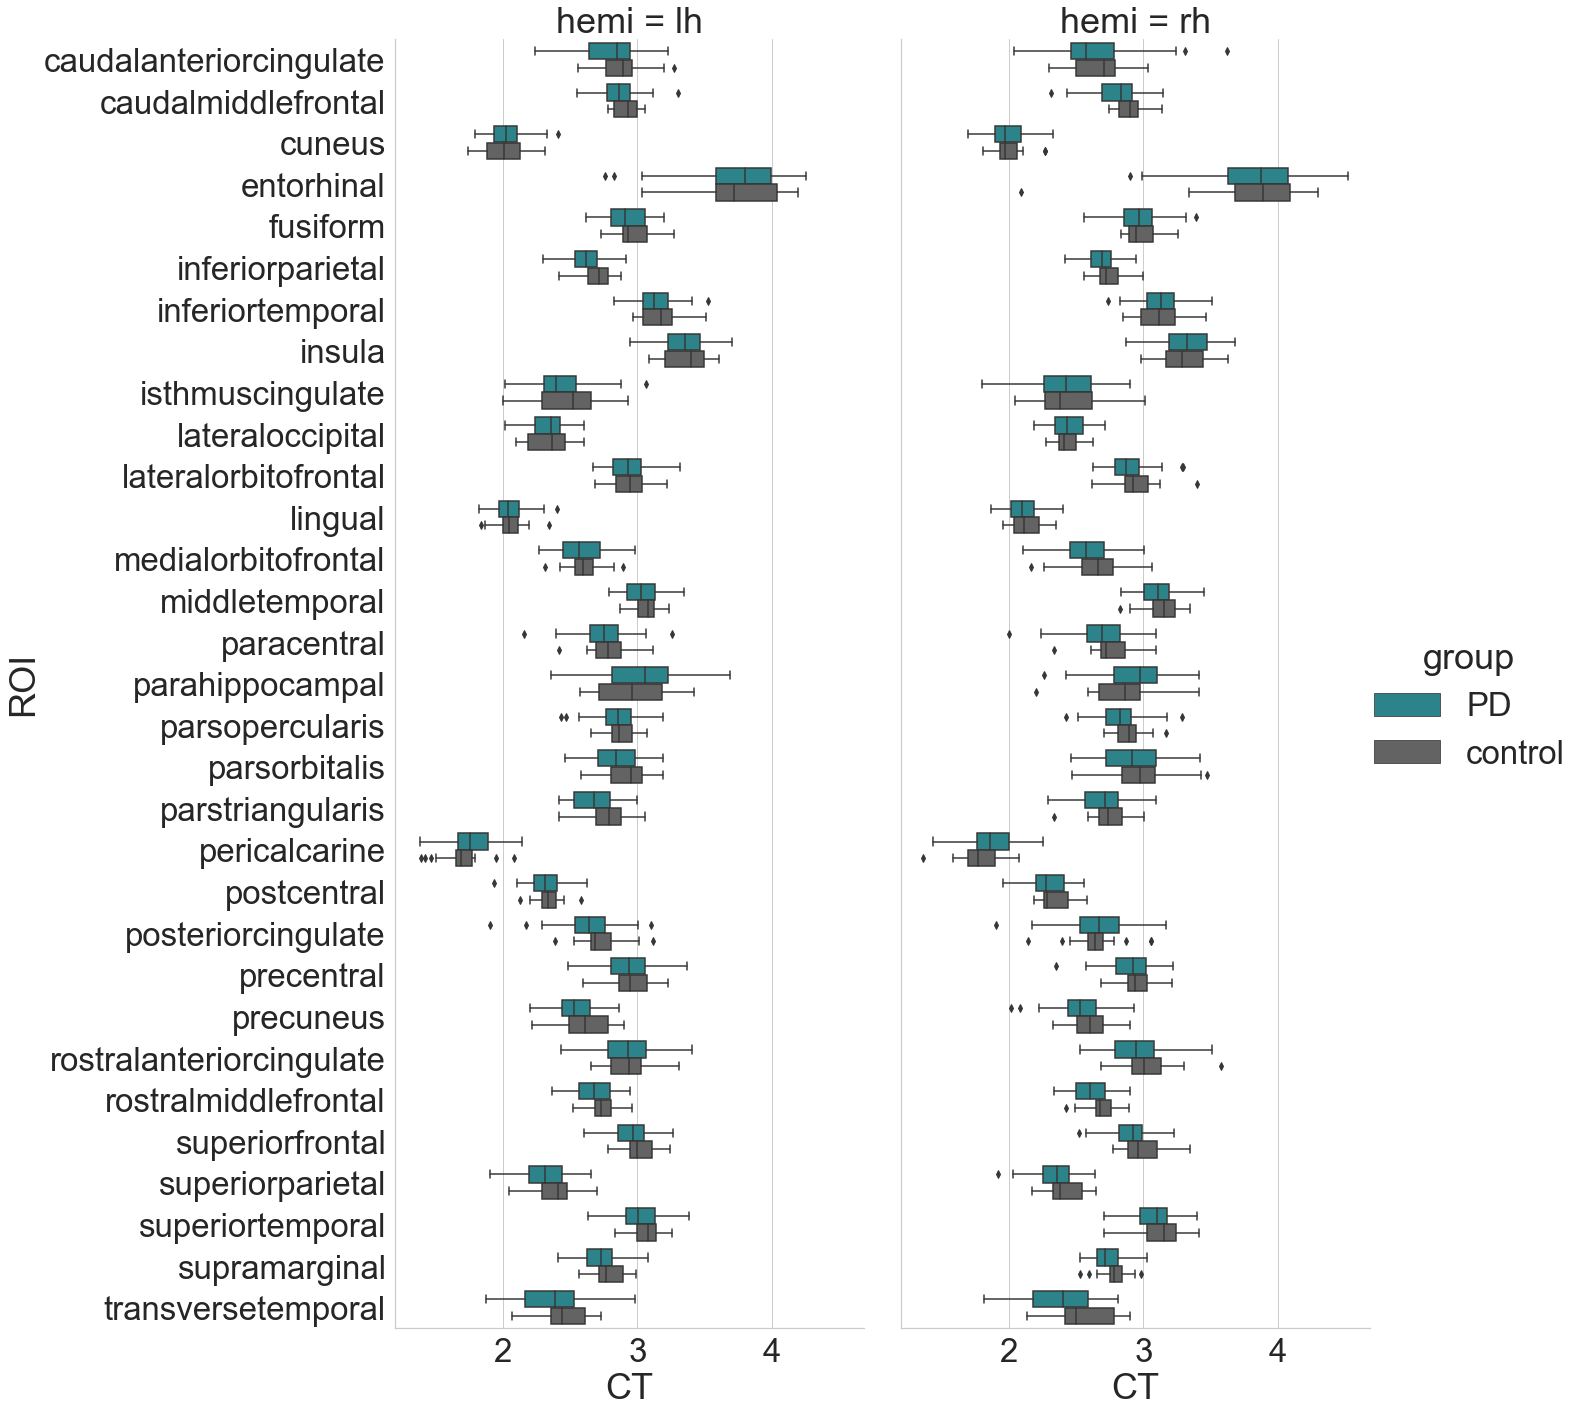

In [11]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [25]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df = vol_ASEG_df.drop(columns=["Unnamed: 0"])
vol_ASEG_df = vol_ASEG_df.rename(columns={"subject_id":"bids_id"})

bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

# Subset fields because UKB has more fields than freesurfer enlists
lh_ASEG_fields = list(set(lh_ASEG_fields) & set(vol_ASEG_df.columns))
rh_ASEG_fields = list(set(rh_ASEG_fields) & set(vol_ASEG_df.columns))
global_ASEG_fields = list(set(global_ASEG_fields) & set(vol_ASEG_df.columns))

# Merge with demographics info
vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df,on="bids_id",how="left")

vol_ASEG_df.head()

n_bids: 86


,bids_id,26523,26524,26525,26564,26595,26563,26594,26526,26514,...,26598,26529,26566,26597,participant_id,age,sex,group,visit,session
0,sub-SERB088,1259.500000,1359.300049,0.0,394.600006,468.899994,1659.300049,1868.099976,19407.699219,1105328.0,...,744.500000,0.0,125.800003,37.799999,SERB088,54.0,M,PD,V01,ses-01
1,sub-SERB058,1318.400024,1266.199951,0.0,177.800003,458.500000,1223.000000,1698.300049,17641.599609,967975.0,...,615.599976,0.0,24.000000,19.700001,SERB058,64.0,M,PD,V01,ses-01
2,sub-SERB049,2289.100098,1639.900024,0.0,431.500000,528.200012,1357.099976,1537.400024,23659.800781,1150341.0,...,921.400024,0.0,29.299999,31.799999,SERB049,62.0,M,PD,V01,ses-01
3,sub-SERB084,2770.500000,2121.199951,0.0,349.500000,440.000000,1344.599976,1407.699951,16605.400391,913761.0,...,669.400024,0.0,13.900000,18.400000,SERB084,NaN,NaN,PD,V01,ses-01
4,sub-SERB063,1231.800049,1374.599976,0.0,403.799988,509.100006,1442.900024,1640.400024,16055.400391,970469.0,...,574.700012,0.0,40.000000,10.400000,SERB063,56.0,M,PD,V01,ses-01


### Split DKT data into left and right hemisphere

In [26]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[lh_ASEG_fields + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[rh_ASEG_fields + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_ASEG_fields + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_ASEG_field_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_ASEG_field_roi_dict)
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_field_roi_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{results_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{results_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

,Lateral-Ventricle,Accumbens-area,Cerebellum-Cortex,vessel,VentralDC,Cerebellum-White-Matter,Amygdala,Caudate,Thalamus-Proper,Inf-Lat-Vent,Pallidum,choroid-plexus,Putamen,Hippocampus,participant_id,age,sex,group,hemi
0,9170.500000,394.600006,49608.800781,125.800003,3958.899902,14102.900391,1659.300049,3355.899902,6357.399902,305.000000,2000.800049,684.400024,4586.500000,3580.399902,SERB088,54.0,M,PD,lh
1,7667.399902,177.800003,42569.199219,24.000000,3381.600098,12641.299805,1223.000000,2633.600098,5716.799805,499.500000,1638.900024,623.900024,3512.899902,3400.500000,SERB058,64.0,M,PD,lh
2,16945.599609,431.500000,50561.199219,29.299999,3974.399902,20009.800781,1357.099976,3021.699951,6195.899902,773.900024,2295.199951,1066.400024,4779.700195,3541.500000,SERB049,62.0,M,PD,lh
3,10064.700195,349.500000,41859.898438,13.900000,3525.199951,10348.900391,1344.599976,1672.599976,5412.100098,195.899994,1645.500000,818.299988,2910.699951,3827.000000,SERB084,NaN,NaN,PD,lh
4,8531.599609,403.799988,46157.500000,40.000000,3328.600098,11251.599609,1442.900024,2352.199951,5824.899902,580.599976,1618.900024,592.799988,3410.100098,3377.800049,SERB063,56.0,M,PD,lh


### Plot ASEG
- hemi 
- global

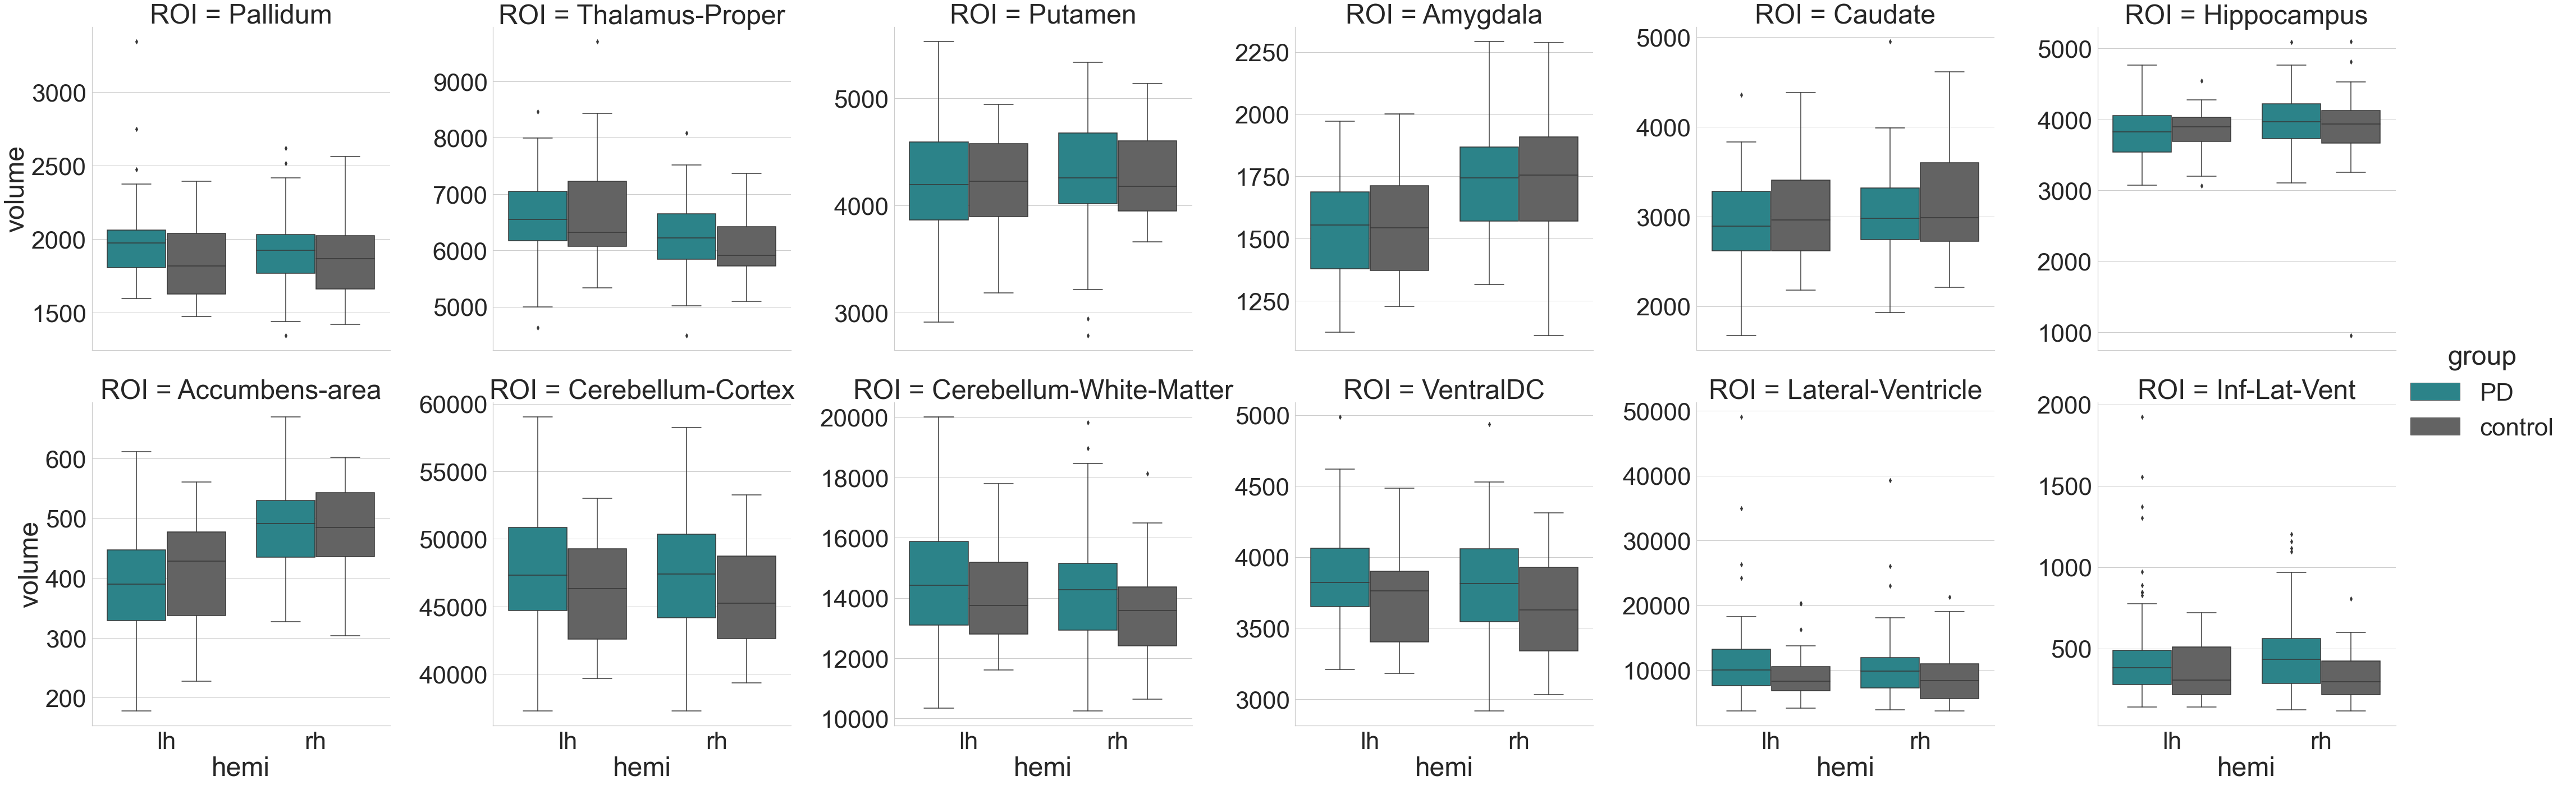

In [14]:
save_fig = False

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

In [ ]:
save_fig = False

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["EstimatedTotalIntraCranial", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Surface maps

In [30]:
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
cmap = "Spectral" #"cubehelix"
view = "lateral" #"lateral" #'medial'
sns.set(font_scale=2)

In [ ]:
fwhm_list = [10] #[0,5,10]
DX_groups = ["control","PD"] 
hemi_list = ["lh", "rh"]
vmax = 4.3

for fwhm in fwhm_list:
    for i, group in enumerate(DX_groups):
        for j, hemi in enumerate(hemi_list):
            CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{group}_{fwhm}mm.mgh")
            avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))

            stat_map = avg_CT

            if hemi == "lh":
                hemisphere = "left"
            else:
                hemisphere = "right"

            bg_map=fsaverage[f"sulc_{hemisphere}"]
            fs_surf = fsaverage[f'pial_{hemisphere}']
            
            fig = plt.figure(figsize=(10, 6))
            fig_file = f"{figs_dir}/surf/{view}/{hemi}_surf_CT_{group}_{fwhm}mm.png"
            
            with sns.axes_style("white"):
                plotting.plot_surf_stat_map(
                    fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
                    colorbar=True, threshold=1, vmax=vmax, output_file=fig_file, cmap=cmap, figure=fig
            )

#bg_map=bg_map,vmax=4.5,

### CTRL - PD

In [31]:
fwhm = 10
cmap = "Spectral"
hemi_list = ["lh", "rh"]
vmax = 0.35 
threshold = 0.1 

for j, hemi in enumerate(hemi_list):
    CT_img_CTRL = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_control_{fwhm}mm.mgh")
    avg_CT_CTRL = np.squeeze(np.mean(CT_img_CTRL.get_fdata(),axis=3))

    CT_img_PD = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_PD_{fwhm}mm.mgh")
    avg_CT_PD = np.squeeze(np.mean(CT_img_PD.get_fdata(),axis=3))

    stat_map = avg_CT_CTRL - avg_CT_PD

    if hemi == "lh":
        hemisphere = "left"
    else:
        hemisphere = "right"

    bg_map=fsaverage[f"sulc_{hemisphere}"]
    fs_surf = fsaverage[f'pial_{hemisphere}']
    
    fig = plt.figure(figsize=(10, 6))
    fig_file = f"{figs_dir}/surf/{view}/{hemi}_surf_CT_diff_{fwhm}mm.png"
    
    with sns.axes_style("white"):
        plotting.plot_surf_stat_map(
            fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
            colorbar=True, threshold=threshold, vmax=vmax, output_file=fig_file, cmap=cmap, figure=fig
        )